In [1]:
DIR = "./";

## Basic Framework

In [2]:
PATH_TO_GAPSE ="../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions
using Printf, LaTeXStrings, TwoFAST, GridInterpolations

In [6]:
FILE_F_MAP =  DIR * "F_pi2.txt";

xs = [x for x in 0:0.05:5]
μs = union(
        [μ for μ in range(-1.0, -0.95, length = 50)], 
        [μ for μ in range(-0.95, 0.95, length = 50)],
        [μ for μ in range(0.95, 1.0, length = 50)]
    )
GaPSE.print_map_F(FILE_F_MAP, 
    xs, μs; 
    trap = true,
    Fmap_opts = Dict(
         :θ_max => π / 2.0, :tolerance => 1e-8, 
         :N => 1000, :pr => true
    )
)

window F evaluation: 100%|██████████████████████████████| Time: 0:06:42


In [17]:
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat";

z_min, z_max, θ_max = 1.0, 1.5, π / 2.0
WFI_opts = Dict(
    :ss_start => 0.0, :ss_stop => 0.0, 
    :ss_step => 100, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 1000, #:pr => true,
)

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.5,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = WFI_opts,
);

In [18]:
FILE_IF_MAP = DIR * "IntF_pi2_z151.txt";

new_calc_μs = union([μ for μ in -1.0:0.005:(-0.95)], 
        [μ for μ in -0.95:0.05:0.95], 
        [μ for μ in 0.95:0.005:1.0]);

GaPSE.print_map_IntegratedF(
    FILE_F_MAP, FILE_IF_MAP, 
    z_min, z_max, new_calc_μs, FILE_BACKGROUND;
    trap = true, WFI_opts...
)

calculating intF: 100%|█████████████████████████████████| Time: 0:00:18


In [19]:
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt";
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "./F_pi2.txt"
# - Integrated F window function input file: "./IntF_pi2_z151.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.5 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 100 	 N = 1000 	 rtol = 0.05 	 
#	 llim = 0.0 	 a

## Check for Window Function F and its integrated version

In [29]:
my_matrix = readdlm(FILE_F_MAP, comments=true)
my_xs = convert(Vector{Float64}, my_matrix[:,1])
my_μs = convert(Vector{Float64}, my_matrix[:,2])
my_Fs = convert(Vector{Float64}, my_matrix[:,3]);
my_F_grid = GridInterpolations.RectangleGrid( unique(my_μs), unique(my_xs))
my_spline_F(x, μ) = GridInterpolations.interpolate(my_F_grid, my_Fs, [μ, x]);

In [30]:
my_Imatrix = readdlm(FILE_IF_MAP, comments=true)
my_Iss = convert(Vector{Float64}, my_Imatrix[:,1])
my_Iμs = convert(Vector{Float64}, my_Imatrix[:,2])
my_IFs = convert(Vector{Float64}, my_Imatrix[:,3]);
my_IF_grid = GridInterpolations.RectangleGrid( unique(my_Iμs), unique(my_Iss))
my_spline_IF(s, μ) = GridInterpolations.interpolate(my_IF_grid, my_IFs, [μ, s]);

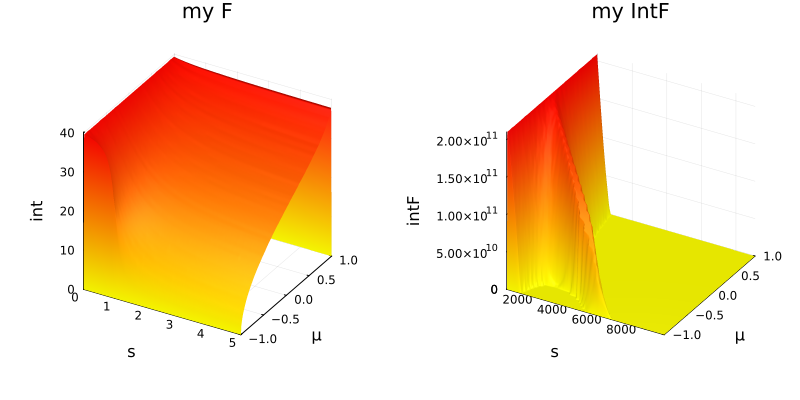

In [31]:
gr()
p1 = plot(my_xs, my_μs, my_Fs; xl="s", yl="μ", zl="int", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my F", legend = false)
p2 = plot(my_Iss, my_Iμs, my_IFs; xl="s", yl="μ", zl="intF", 
    st = :surface, c=cgrad([:yellow, :red]), #size=(600, 300), 
    title="my IntF", legend = false)
p3 = plot(p1, p2, size=(800, 400))

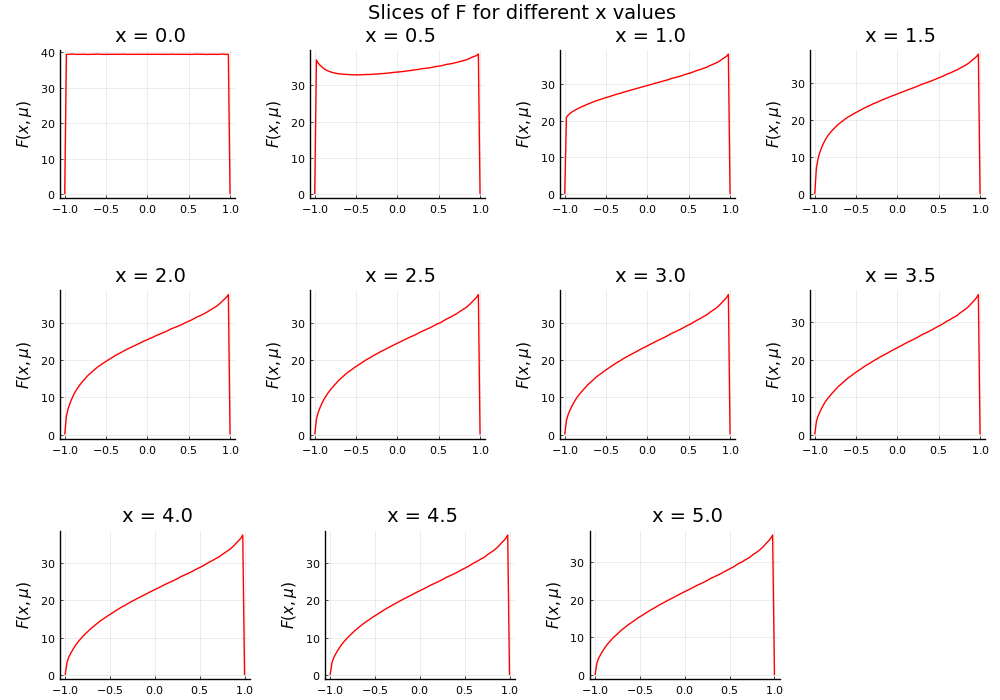

In [32]:
pyplot()

title = plot(title = "Slices of F for different x values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(xs)]
for (i,x) in enumerate(xs)
    tit = "\n\n x = $x"
    xs_1 = μs
    ys_1 = [my_spline_F(x, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"F(x,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c d ; e f g h ; i l j _]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,700))

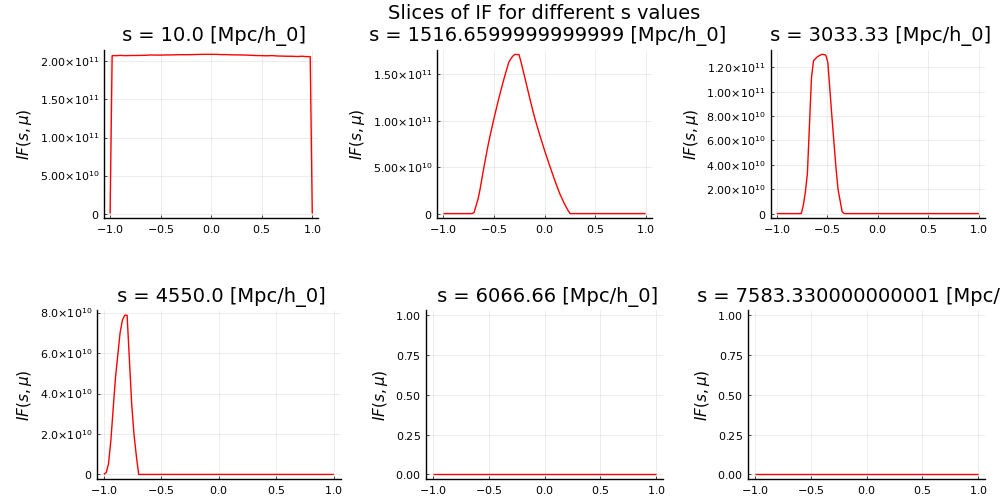

In [33]:
pyplot()

title = plot(title = "Slices of IF for different s values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
ss = vcat([10.0], [i*max(my_Iss...)/6 for i in 1:5]);
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(ss)]
for (i,s) in enumerate(ss)
    tit = "\n\n s = $(trunc_n(s)) [Mpc/h_0]"
    xs_1 = μs
    ys_1 = [my_spline_IF(s, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"IF(s,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c ; d e f ]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,500))

## Other stuff

In [25]:
IMPLEMENTED_GR_EFFECTS = [
     "auto_newton", "auto_doppler", "auto_lensing",
     "auto_localgp", "auto_integratedgp", 
     
     "newton_doppler", "doppler_newton",
     "newton_lensing", "lensing_newton",
     "newton_localgp", "localgp_newton",
     "newton_integratedgp", "integratedgp_newton",
     "lensing_doppler", "doppler_lensing",
     "doppler_localgp", "localgp_doppler",
     "doppler_integratedgp", "integratedgp_doppler",
     "lensing_localgp", "localgp_lensing",
     "lensing_integratedgp", "integratedgp_lensing",
     "localgp_integratedgp", "integratedgp_localgp",
];


ξs_names = [
    L"$\xi^{\delta \, \delta}_{L=0}(s)$", 
    L"$\xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)$", 
    L"$\xi^{\kappa \, \kappa}_{L=0}(s)$", 
    L"$\xi^{\phi \, \phi}_{L=0}(s)$", 
    L"$\xi^{\int\phi \, \int\phi}_{L=0}(s)$", 
    
    L"$\xi^{\delta \, v_{\parallel}}_{L=0}(s)$",
    L"$\xi^{v_{\parallel} \, \delta}_{L=0}(s)$",
    
    L"$\xi^{\delta \, \kappa}_{L=0}(s)$",
    L"$\xi^{\kappa \, \delta}_{L=0}(s)$",
    
    L"$\xi^{\delta \, \phi}_{L=0}(s)$",
    L"$\xi^{\phi \, \delta}_{L=0}(s)$",
    
    L"$\xi^{\delta \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, \delta}_{L=0}(s)$",
    
    L"$\xi^{\kappa \, v_{\parallel}}_{L=0}(s)$",
    L"$\xi^{v_{\parallel} \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{v_{\parallel} \, \phi}_{L=0}(s)$",
    L"$\xi^{\phi \, v_{\parallel}}_{L=0}(s)$",
    
    L"$\xi^{v_{\parallel} \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, v_{\parallel}}_{L=0}(s)$",
    
    L"$\xi^{\kappa \, \phi}_{L=0}(s)$",
    L"$\xi^{\phi \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{\kappa \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, \kappa}_{L=0}(s)$",
    
    L"$\xi^{\phi \, \int\phi}_{L=0}(s)$",
    L"$\xi^{\int\phi \, \phi}_{L=0}(s)$",
];

INDEX_GR_EFFECT = Dict([name => i for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);
GR_EFFECT_INDEXED = Dict([i => name for (i, name) in 
            enumerate(IMPLEMENTED_GR_EFFECTS)]...);

## Computations

In [49]:
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L0_noF_noobsvel.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    single = true, use_windows = false, enhancer = 1e6, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false,
    N_χs = 100, N_χs_2 = 30, obs = :noobsvel);

auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:52
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:01
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:09
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:08
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:02
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:02
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:02
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:02
doppler_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:00
integratedgp_doppler, L=0: 100%|████████████████████████| Time: 0:00:01
lensing_localgp, L=0: 100%|█████████████████████████████| Time: 0:00:01
localgp_lensing, L=0: 100%|█████████████████████████████| Time: 0:00:02
lensing_integratedgp, L=0: 100%|████████████████████████| Time: 0:00:04
integratedgp_lensing, L=0: 100%|████████████████████████| Time: 


time needed for map_sum_ξ_GNC_multipole [in s] = 101.73157 



In [68]:
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L2_noF_noobsvel.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 130);
    single = true, use_windows = false, enhancer = 1e6, L=2,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false,
    N_χs = 100, N_χs_2 = 30, obs = :noobsvel);

LoadError: InterruptException:

In [51]:
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L0_withF_noobsvel.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    single = true, use_windows = true, enhancer = 1e6, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false,
    N_χs = 100, N_χs_2 = 30, obs = :noobsvel);

auto_newton, L=0: 100%|█████████████████████████████████| Time: 0:00:00
auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:00
auto_lensing, L=0: 100%|████████████████████████████████| Time: 0:00:25
auto_integratedgp, L=0: 100%|███████████████████████████| Time: 0:00:03
newton_doppler, L=0: 100%|██████████████████████████████| Time: 0:00:00
doppler_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_lensing, L=0: 100%|██████████████████████████████| Time: 0:00:05
lensing_newton, L=0: 100%|██████████████████████████████| Time: 0:00:06
newton_localgp, L=0: 100%|██████████████████████████████| Time: 0:00:00
localgp_newton, L=0: 100%|██████████████████████████████| Time: 0:00:00
newton_integratedgp, L=0: 100%|█████████████████████████| Time: 0:00:02
integratedgp_newton, L=0: 100%|█████████████████████████| Time: 0:00:02
lensing_doppler, L=0: 100%|█████████████████████████████| Time: 0:00:02
doppler_lensing, L=0: 100%|█████████████████████████████| Time: 


time needed for map_sum_ξ_GNC_multipole [in s] = 76.63802 



In [59]:
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR * "GNC_sb0_fevo0_L2_withF_noobsvel.txt", 
    10 .^ range(0, log10(2*cosmo.s_max), length = 300);
    single = true, use_windows = true, enhancer = 1e6, L=2,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = false,
    N_χs = 100, N_χs_2 = 30, obs = :noobsvel);

auto_newton, L=2: 100%|█████████████████████████████████| Time: 0:00:00
auto_doppler, L=2: 100%|████████████████████████████████| Time: 0:00:00


LoadError: InterruptException:

## Reading the TPCFs files

In [60]:
ss_L0_noF_noobsvel, res_sums_L0_noF_noobsvel, res_xis_L0_noF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L0_noF_noobsvel.txt", comments=true);
ss_L2_noF_noobsvel, res_sums_L2_noF_noobsvel, res_xis_L2_noF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L2_noF_noobsvel.txt", comments=true);

ss_L0_withF_noobsvel, res_sums_L0_withF_noobsvel, res_xis_L0_withF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L0_withF_noobsvel.txt", comments=true);
ss_L2_withF_noobsvel, res_sums_L2_withF_noobsvel, res_xis_L2_withF_noobsvel =
    GaPSE.readxyall(DIR * "GNC_sb0_fevo0_L2_withF_noobsvel.txt", comments=true);

LoadError: ArgumentError: Cannot open './GNC_sb0_fevo0_L2_noF_noobsvel.txt': not a file

## Plots

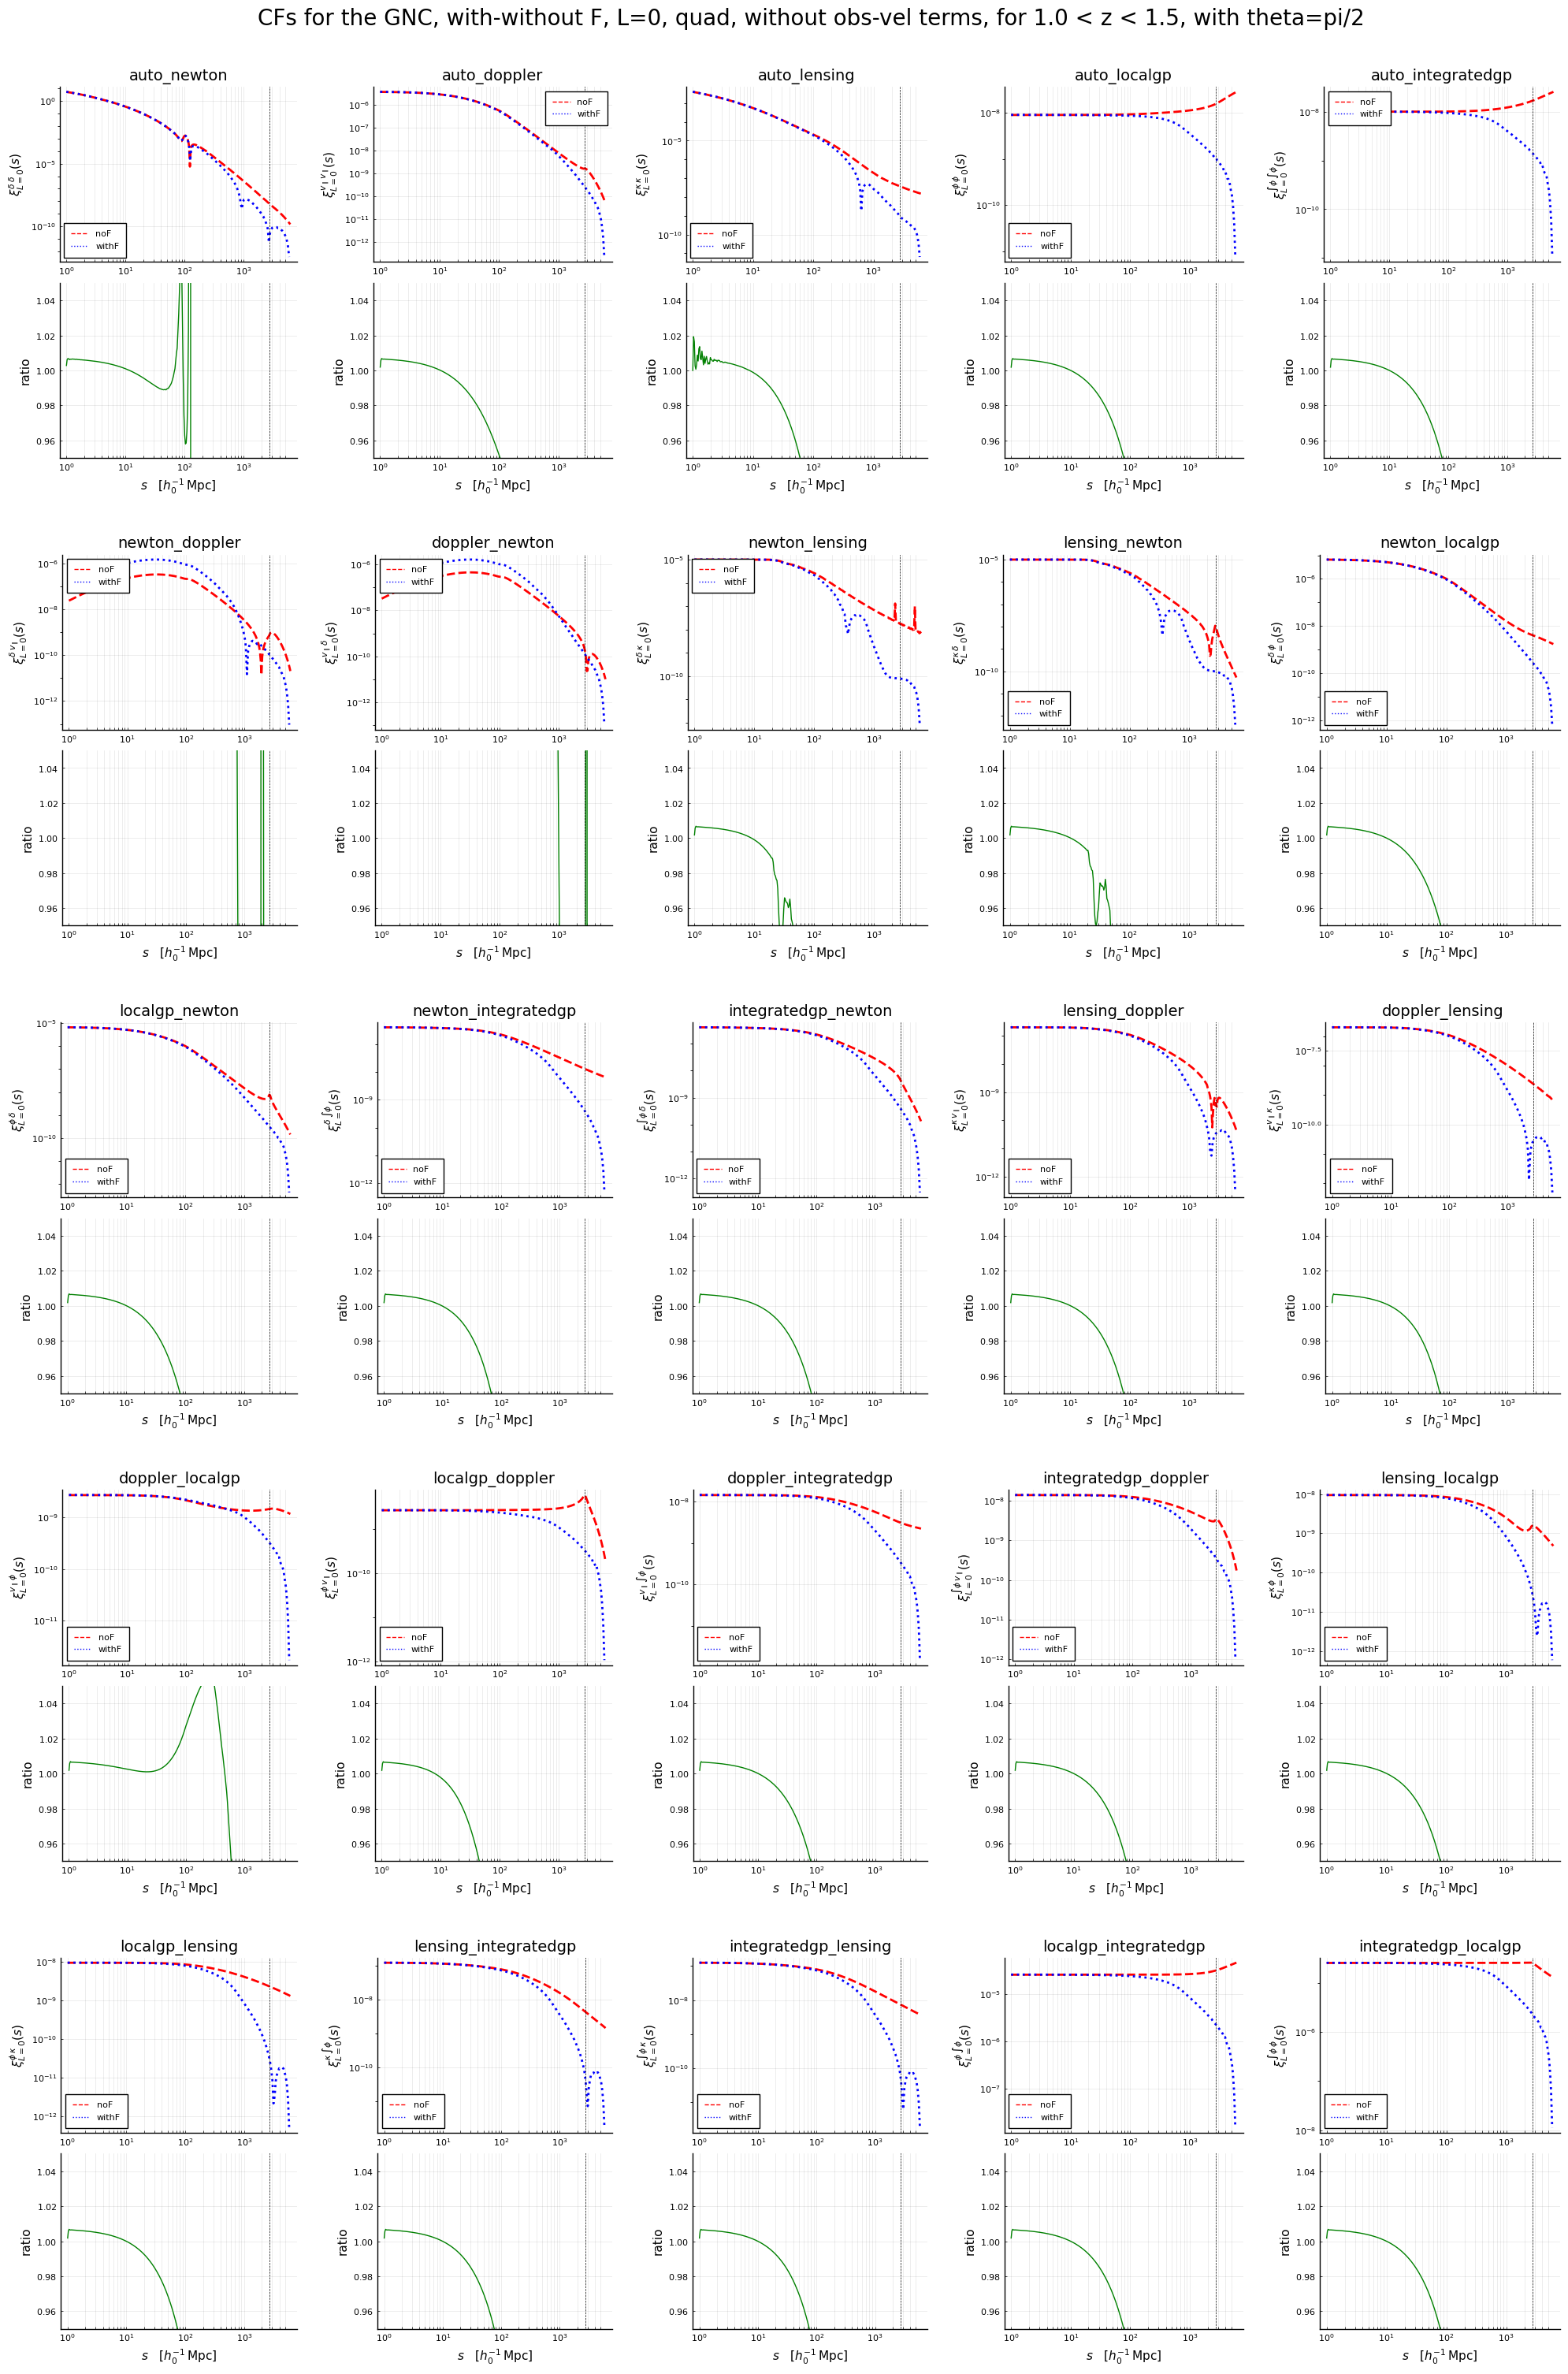

In [61]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with-without F, L=0, quad, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

legend_pos=[
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = "\n\n"*effect
    xs_1 = ss_L0_noF_noobsvel
    ys_1 = res_xis_L0_noF_noobsvel[i]
    xs_2 = ss_L0_withF_noobsvel
    ys_2 = res_xis_L0_withF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["noF" "withF"], title=tit,
        #ylabel=L"s^2 \," * ξs_names[i],
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=ξs_names[i],
        legend=legend_pos[i])
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio",
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(2000,3000))

savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L0_noF-withF_noobsvel.pdf")
#display(P)

In [62]:
pyplot()
LIST_P = [plot() for i in 1:length(IMPLEMENTED_GR_EFFECTS)]

title = plot(title = "CFs for the GNC, with-without F, L=2, quad, without obs-vel terms, for 1.0 < z < 1.5, with theta=pi/2", grid=false, 
    showaxis = false, bottom_margin = -30Plots.px, ticks=false, titlefontsize=20)

legend_pos=[
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
     :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]

for (i,effect) in enumerate(IMPLEMENTED_GR_EFFECTS)
    tit = "\n\n"*effect
    xs_1 = ss_L2_noF_noobsvel
    ys_1 = res_xis_L2_noF_noobsvel[i]
    xs_2 = ss_L2_withF_noobsvel
    ys_2 = res_xis_L2_withF_noobsvel[i]

    spline = Spline1D(xs_2, ys_2)

    S_VLIM = cosmo.s_eff
    S_VLIM_F = @sprintf("%.2f", S_VLIM)

    p1 = plot(
        #[xs_1, xs_2], [ys_1 .* xs_1 .^2, ys_2 .* xs_2 .^2], 
        #[xs_1, xs_2], [abs.(ys_1), abs.(ys_2)], 
        [xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]], 
        lc=[:red :blue], ls=[:dash :dot], lw = [2 2],
        label=["noF" "withF"], title=tit,
        #ylabel=L"s^2 \," * ξs_names[i],
        axis =:log,
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        grid=true,
        ylabel=ξs_names[i],
        legend=legend_pos[i])
    #[vline!(p1, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p1, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    p2 = plot(xs_1, spline.(xs_1) ./ ys_1, label="Ratio", 
        lc=:green, xaxis=:log,
        ylim=(0.95,1.05), 
        legend=:false, ylabel="ratio",
        xticks = (
            vcat([a*10.0^b for b in 0:2 for a in 1:9], [a*10.0^3 for a in 1:5]), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in 0:2 for a in 1:9], L"10^{3}",[nothing for a in 2:5 ])
        ),
        xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
    #[vline!(p2, [a*10.0^b], lc=:grey, lw=0.4, ls=:solid, label=false) for b in 0:3 for a in [1.0 5.0]]
    vline!(p2, [S_VLIM], label = false, #label="$S_VLIM_F Mpc/h_0", 
        lc=:black, lw=0.5, ls=:dash)

    LIST_P[i] = plot(p1, p2, size=(20, 40),
        layout= @layout [ x ; z ])
end

#l = @layout [a b ; c d ; e f ; g h ; i l ; m n ; o p ; q r ]
l = @layout [
    A{0.05h} 
    a  b  c
    d e _
    A B C D
    E F G H
    I L M N
    O P Q R
    S T U V
]

ll = @layout [ 
    A{0.01h}
    grid(5,5) 
]
ALL_PLOTS = plot(title, LIST_P..., layout = ll,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(2000,3000))

savefig(ALL_PLOTS, DIR * "GNC_sb0_fevo0_L2_noF-withF_noobsvel.pdf")
#display(P)

LoadError: UndefVarError: ss_L2_noF_noobsvel not defined